In [2]:
from acquire import get_telco_data
from prepare import train_validate_test_split, prep_telco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import explore
from scipy import stats

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [3]:
df = get_telco_data()

df = prep_telco(df)


Using cached data


In [5]:
train, validate, test = train_validate_test_split(df, target = 'churn', seed =123)

In [6]:
train.head()

,customer_id,is_senior_citizen,tenure,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,...,internet_service_type,payment_type,is_male,has_phone,has_internet_service,has_partner,has_dependent,is_paperless,is_month_to_month,is_autopay
5919,8331-ZXFOE,0,58,Yes,Yes,Yes,Yes,Yes,No,No,...,DSL,Credit card (automatic),0,1,1,0,0,1,0,1
1915,2790-XUYMV,0,71,Yes,Yes,Yes,No,No,No,No,...,Fiber optic,Credit card (automatic),1,1,1,0,1,1,0,1
5054,7107-UBYKY,0,35,Yes,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,...,None,Electronic check,0,1,0,1,1,1,1,0
2355,3373-YZZYM,0,1,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,...,None,Mailed check,1,1,0,1,1,0,1,0
6279,8883-GRDWQ,1,20,No,Yes,No,No,Yes,No,No,...,DSL,Mailed check,1,1,1,0,0,0,0,0


In [10]:
# Baseline churn rate
baseline_churn = (train.churn == 0).mean()

In [11]:
print(baseline_churn)

0.7343154686309372


In [9]:
train.columns

Index(['customer_id', 'is_senior_citizen', 'tenure', 'multiple_lines',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'paperless_billing',
       'monthly_charges', 'total_charges', 'churn', 'contract_type',
       'internet_service_type', 'payment_type', 'is_male', 'has_phone',
       'has_internet_service', 'has_partner', 'has_dependent', 'is_paperless',
       'is_month_to_month', 'is_autopay'],
      dtype='object')

In [160]:
selected_features = ['monthly_charges','is_autopay','has_internet_service','tenure','is_month_to_month']
target = 'churn'

In [168]:
X_train = train[selected_features]
y_train = train[[target]]

X_validate = validate[selected_features]
y_validate = validate[[target]]

X_test = test[selected_features]
y_test = test[[target]]

In [169]:
clf = DecisionTreeClassifier(max_depth=3, random_state=123)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)

In [193]:
def decision_tree_train(X_train, y_train, selected_features=selected_features, target=target, d = 10, m=1, print_results = True):
  
    clf = DecisionTreeClassifier(max_depth=d, min_samples_leaf = m, random_state=123)
    clf = clf.fit(X_train, y_train)
    accuracy = clf.score(X_train, y_train)
    y_pred = clf.predict(X_train)
    class_report = classification_report(y_train, y_pred,output_dict=True)
    
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
        
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    if print_results:
        print("TRAINING RESULTS")
        print("----------------")
        print(f"Accuracy score on training set is: {accuracy:.2f}")
        print(classification_report(y_train, y_pred))


        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    
    train_report = {'d':d, 
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return clf, train_report

def classifier_validate(X_validate, y_validate, clf, print_results=True):
    d = clf.max_depth
    accuracy = clf.score(X_validate, y_validate)


    # Produce y_predictions that come from the X_validate
    y_pred = clf.predict(X_validate)
    
    class_report = classification_report(y_validate, y_pred,output_dict=True)
    tn, fp, fn, tp = confusion_matrix(y_validate, y_pred).ravel()
    
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    # Compare actual y values (from validate) to predicted y_values from the model run on X_validate
    if print_results:
        print("-----VALIDATE RESULTS-----")
        print(classification_report(y_validate, y_pred))

        print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
             .format(accuracy))
    validate_report = {'d':d, 
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return validate_report

In [194]:
depths =[]
min_samples = []
accuracies = []
precisions = []
recalls = []
for d in range(1, 100):
    min_sample=1
    clf, train_report = decision_tree_train(X_train, y_train, d=4, m = min_sample , print_results=False)
    depths.append(d)
    min_samples.append(min_sample)
    accuracies.append(train_report['accuracy'])
    precisions.append(train_report['precision'])
    recalls.append(train_report['recall'])

train_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":accuracies,"precision":precisions,"recall":recalls})

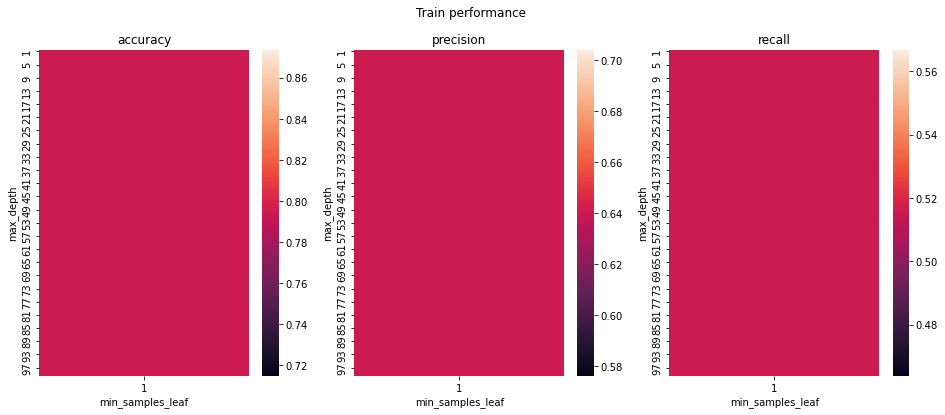

In [195]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    heatmap_df = train_results_df.pivot("max_depth","min_samples_leaf",metric)
    sns.heatmap(heatmap_df, ax=ax[i])
    plt.suptitle('Train performance')
    ax[i].set_title(metric)

<AxesSubplot:xlabel='max_depth', ylabel='accuracy'>

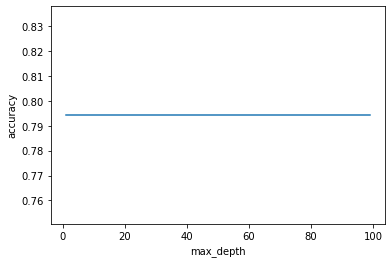

In [196]:
sns.lineplot(data = train_results_df, x = 'max_depth', y = 'accuracy')

In [220]:
depths =[]
min_samples = []
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []
min_sample_leafs = m = 1

for d in range(2, 15):

        clf, train_report = decision_tree_train(X_train,y_train,selected_features,target, d, m, print_results=False)
        validate_report = classifier_validate(X_validate,y_validate, clf, print_results=False)

        depths.append(d)
        min_samples.append(min_sample)
        train_accuracies.append(train_report['accuracy'])
        train_precisions.append(train_report['precision'])
        train_recalls.append(train_report['recall'])

        v_accuracies.append(validate_report['accuracy'])
        v_precisions.append(validate_report['precision'])
        v_recalls.append(validate_report['recall'])

train_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['max_depth','min_samples_leaf'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train

combined_df = combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train: {combined_df.accuracy_train.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate: {combined_df.accuracy_validate.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_validate.idxmax()]}")

Highest accuracy score on train: 0.9123698247396494 with max depth setting of 14
Highest accuracy score on validate: 0.7778436018957346 with max depth setting of 5


In [221]:
combined_df.head(1)

,max_depth,min_samples_leaf,accuracy_train,precision_train,recall_train,accuracy_validate,precision_validate,recall_validate,accuracy_diff,precision_diff,recall_diff
3,5,1,0.801626,0.6901,0.459847,0.777844,0.614198,0.443207,-0.023782,-0.075903,-0.01664


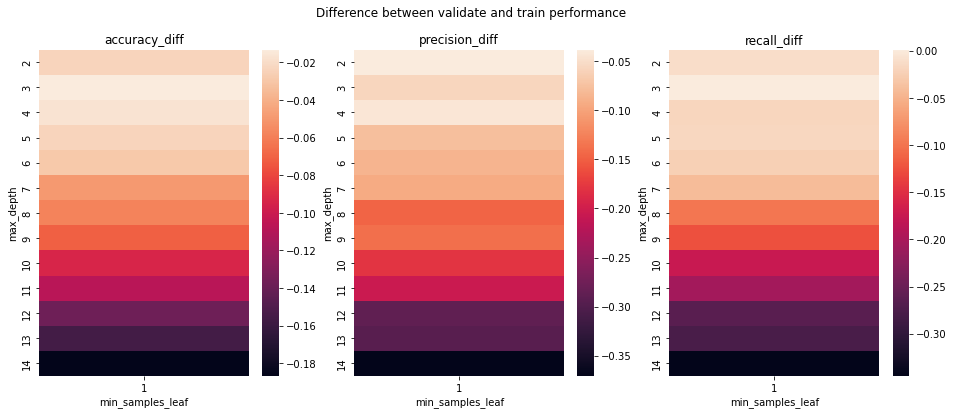

In [206]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy_diff","precision_diff","recall_diff"]
for i, metric in enumerate(to_plot):
    heatmap_df = combined_df.pivot("max_depth","min_samples_leaf",metric)
    sns.heatmap(heatmap_df, ax=ax[i])
    plt.suptitle('Difference between validate and train performance')
    ax[i].set_title(metric)